In [1]:
#This notebook is to look at the accumulated charge distribution and
# subtract either the estimate bkg using the error rate or the observed bkg.
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from sklearn.linear_model import LinearRegression
list(colormaps)
cmap = 'gist_heat'
from functools import partial

def checkZ2Charge(key):
    ''' 
    This function takes a bitstring key and returns the charge information.
    One key notice: the charge output tracks the number of 1s in the bitstring by summing the values
    However, the number of charges is defined as the number of 0s.
    the real "charge number" should be nsites - charge.
    '''
    charge = []
    for i in np.arange(0,len(key),1): # Assuming first and last are matter site.

        if i%2 == 0:
            charge.append(int(key[i]))
    charge = np.array(charge)
    return charge

nSites = 27
matter_defect=[27]
initial_charge = 26
initialKey = '10101010101010101010101010001010101010101010101010101'
initialCharge_key = checkZ2Charge(initialKey)
#evo_strings_name  = "Torino_53RealTimeEvo_2025-05-27_strings.pkl"
evo_strings_name = "../Torino_53RealTimeEvo_2025-07-28_strings.pkl"
evo_strings = np.load(evo_strings_name ,allow_pickle=True)



In [2]:
def getNstrings(strings_set):
    ''' 
    This function loops through sets of bitstrings and count the total number of strings
    '''
    nStrings = np.zeros(nSites+1)
    sum_all = 0
    for subset in strings_set:
        #print("Starting new subset")
        for string_key in subset.keys():
            charge_arr = checkZ2Charge(string_key)
            nCharges = nSites - sum(charge_arr)
            sum_all += subset[string_key]
            nStrings[nCharges] += subset[string_key]
    print("Total sum of strings: ", sum_all)
    return nStrings, sum_all

def buildP_all(strings_set,nCharge_max = 15):
    ''' 
    Builds the probability distribution based on the set of strings.
    nCh
    arge_max sets the maximum number of charges allowed to be observed.
    For each nCharge observed, the probability distribution is recorded separately.
    Technically, the site has no charge if it is 1 and has a charge when 0. But this is not intuitive. We wanna switch this.
    In the end, returning 1-p such that the 0 < - > 1 conversion is handled for all sites.
    '''
    p = np.zeros((nCharge_max, nSites)) # recording distribution for all charge observations
    sum_all = np.zeros(nCharge_max) # recording total number of strings for each charge observation
    for subset in strings_set:
        #print("Starting new subset")
        for string_key in subset.keys():
            charge_arr = checkZ2Charge(string_key)
            nCharges = nSites - charge_arr.sum()
            if nCharges >= nCharge_max:
                continue

            sum_all[nCharges] += subset[string_key]
            p[nCharges] += charge_arr * subset[string_key]
    p = np.array(p)
    for i in range(nCharge_max):
        if sum_all[i] == 0:
            continue
        p[i] /= sum_all[i]

    print("Total sum of strings: ", sum_all.sum())
    return 1 - p, sum_all
    
import math
def prob_n_charges(n, E, n_charge,return_separate = False):
    ''' 
    Calculates the probability of observing a certain number of charges based on the noise model.
    n: number of sites
    E: average Error rate
    n_charge: number of charges observed
    '''
    if n_charge < 0 or n_charge > n:
        if return_separate:
            return 0, 0
        else:
            return 0
        return 0
    binom = math.comb
    term1 = 0 #with real charge
    if 1 <= n_charge <= n:
        term1 = (1 - E) * binom(n - 1, n_charge - 1) * (E ** (n_charge - 1)) * ((1 - E) ** (n - n_charge))
    
    term2 = 0 #without real charge
    if 0 <= n_charge <= n - 1:
        term2 = E * binom(n - 1, n_charge) * (E ** n_charge) * ((1 - E) ** (n - 1 - n_charge))
    
    if return_separate:
        return term1, term2
    
    else:
        return term1 + term2
        
def getPlist(E,n = nSites):
    ''' 
    For a range of nCharges observed, get the probability distribution for each.
    '''
    p = []
    #probability observing 0 charges is that the charged one must flip
    p.append((1-E)**(nSites - 1) * E) 
    for l in np.arange(1,n,1):
        p.append(prob_n_charges(nSites,E,l))
    p = np.array(p)
    return p

def getPbest(nStrings):
    ''' 
    Use the strings observed to find the best probability distribution.
    ''' 
    p_obs = nStrings/nStrings.sum()
    mean_obs = (p_obs * np.arange(0, len(p_obs),1)).sum()
    E_best = (mean_obs - 1)/(nSites - 2)
    p_best = getPlist(E_best)
    return p_best,E_best



In [3]:
from scipy.optimize import curve_fit

def model_func_float(factors, pr, pf,fit_lower_limit, fit_upper_limit,tmp_E):
    ''' 
    Perform the fit with pr and pf floated.
    '''
    f_bt,f_bf = factors
    return f_bt * pr + (1-pr*f_bt/(1-pf))*f_bf * pf 
        
def getTruth(evo,fit_upper_limit = 7,nCharge_max = 20,n_threshold = 5000):
    nStrings, sum_all = getNstrings(evo)
    tmp_p,tmp_E = getPbest(nStrings)
    print("Best average error rate: ", tmp_E)

    
    p_charge_list, nCharges_list = buildP_all(evo,nCharge_max = nCharge_max)

    nCharges_list_norm = nCharges_list / nCharges_list.sum()
    tmp_p, tmp_E = getPbest(nCharges_list)

    #Compute the Baysian factors excepr for f_bf:
    f_bt_list = []
    f_bf_list = []
    p_nc_list = []
    charge_range = range(0,nCharge_max,1)  
    for tmp_n_charge in charge_range:
        #p(nc,ns):
        p_nc = prob_n_charges(nSites, tmp_E, tmp_n_charge,return_separate = False)
        p_nc_list.append(p_nc)

        #Should pick term 1?
        f_bt = prob_n_charges(nSites, tmp_E, tmp_n_charge,return_separate = True)[0]
        f_bt /= p_nc
        f_bt_list.append(f_bt)

        f_bf_numerator = prob_n_charges(nSites - 1, tmp_E, tmp_n_charge - 1,return_separate = False)
        f_bf_denominator = prob_n_charges(nSites, tmp_E, tmp_n_charge,return_separate = False) 
        f_bf = f_bf_numerator / f_bf_denominator
        f_bf_list.append(f_bf)

    f_bt_list = np.array(f_bt_list)
    f_bf_list = np.array(f_bf_list)
    p_nc_list = np.array(p_nc_list)

    #I want to set the fitting range to be those with sufficient data.
    # For example, set start and end to be those with entries in nCharges_list being more than some threshold
    
    fit_lower_limit = np.where(nCharges_list > n_threshold)[0][0]
    fit_upper_limit = np.where(nCharges_list > n_threshold)[0][-1] + 1
    print("Fitting range: ", fit_lower_limit, fit_upper_limit)


    n_sites = p_charge_list.shape[1]

    pr_list = []
    pf_list = []

    for i in range(n_sites):
        y = p_charge_list[fit_lower_limit:fit_upper_limit, i]
        f_bt = f_bt_list[fit_lower_limit:fit_upper_limit]
        f_bf = f_bf_list[fit_lower_limit:fit_upper_limit]
        
        model_func_fit = partial(model_func_float, fit_lower_limit=fit_lower_limit, fit_upper_limit=fit_upper_limit,tmp_E = tmp_E)
        popr, _ = curve_fit(model_func_fit, (f_bt, f_bf), y, bounds=([0, 0], [1, 1]), p0=[0.5, tmp_E])   
        pr_list.append(popr[0])
        pf_list.append(popr[1])

    pr_list = np.array(pr_list)
    pf_list = np.array(pf_list)

    return pr_list, pf_list

In [4]:
keyList = list(evo_strings.keys())
print(keyList)

['nTrotter_1_evo_0.4', 'nTrotter_2_evo_0.4', 'nTrotter_3_evo_0.4000000000000001', 'nTrotter_3_evo_0.5333333333333333', 'nTrotter_4_evo_0.5', 'nTrotter_5_evo_0.4800000000000001', 'nTrotter_5_evo_0.56', 'nTrotter_6_evo_0.5333333333333333', 'nTrotter_6_evo_0.6', 'nTrotter_7_evo_0.5714285714285714', 'nTrotter_8_evo_0.55', 'nTrotter_9_evo_0.5333333333333334', 'nTrotter_9_evo_0.5777777777777778']


In [5]:
pr_list = []
pf_list = []
# Max = 4
# ii = 0
for key in keyList:
    # if ii >Max:
    #     break
    # ii += 1
    print("Key: ", key)

    pr, pf = getTruth(evo_strings[key])

    pr_list.append(pr)
    pf_list.append(pf)
    print(pr.sum())
pr_list = np.array(pr_list)
pf_list = np.array(pf_list)

Key:  nTrotter_1_evo_0.4
Total sum of strings:  1000000
Best average error rate:  0.14183388
Total sum of strings:  1000000.0
Fitting range:  1 11
1.2210150459855698
Key:  nTrotter_2_evo_0.4
Total sum of strings:  1500000
Best average error rate:  0.18890215999999999
Total sum of strings:  1500000.0
Fitting range:  1 13
1.3622883852946084
Key:  nTrotter_3_evo_0.4000000000000001
Total sum of strings:  2000000
Best average error rate:  0.21143514
Total sum of strings:  1999998.0
Fitting range:  1 14
1.3768621744286682
Key:  nTrotter_3_evo_0.5333333333333333
Total sum of strings:  2000000
Best average error rate:  0.21139332
Total sum of strings:  2000000.0
Fitting range:  1 14
1.3828516747526047
Key:  nTrotter_4_evo_0.5
Total sum of strings:  2500000
Best average error rate:  0.23923752
Total sum of strings:  2499988.0
Fitting range:  1 15
1.3742459794011408
Key:  nTrotter_5_evo_0.4800000000000001
Total sum of strings:  3000000
Best average error rate:  0.277577
Total sum of strings:  29

1.0993529959133084


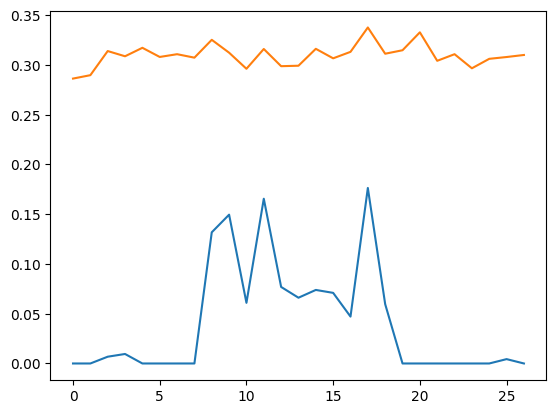

In [6]:
ind = 7
plt.plot(pr_list[ind])
plt.plot(pf_list[ind])
print(pr_list[ind].sum())

In [7]:
def getEVsFromCharge(p_charge):
    ''' 
    Use the Gauge constraint to reconstruct the link values from the charge location.
    p_charge, which is the charge probabilities on sites, fully determines the link values.
    '''
    n_sites = p_charge.shape[0]
    n_qubits = 2*n_sites-1

    center = int((n_qubits-1)/2)
    
    evs = np.ones(n_qubits)
    for i in range(len(evs)):
        if i%2==0:
            evs[i] = 1-p_charge[int(i/2)]
            if i<center:
                for j in np.arange(i,center,1):
                    if j%2==1:
                        evs[j] -= p_charge[int(i/2)]
                        
            if i>center:
                for j in np.arange(center,i,1):
                    if j%2==1:
                        evs[j] -= p_charge[int(i/2)]
                
    return evs

def Symmetrize(p):
    return 0.5*(p+np.flip(p))
    

In [8]:
for i in range(len(pr_list)):
    pr_list[i][pr_list[i]<0] = 0
    #renormalize
    pr_list[i] /= pr_list[i].sum()


In [9]:
evs_list_nopSym = []
evs_list = []
for p in pr_list:
    evs_list_nopSym.append(getEVsFromCharge(p))
    p = Symmetrize(p)
    evs_list.append(getEVsFromCharge(p))
evs_list = np.array(evs_list)
evs_list_nopSym  = np.array(evs_list_nopSym)

<Figure size 640x480 with 0 Axes>

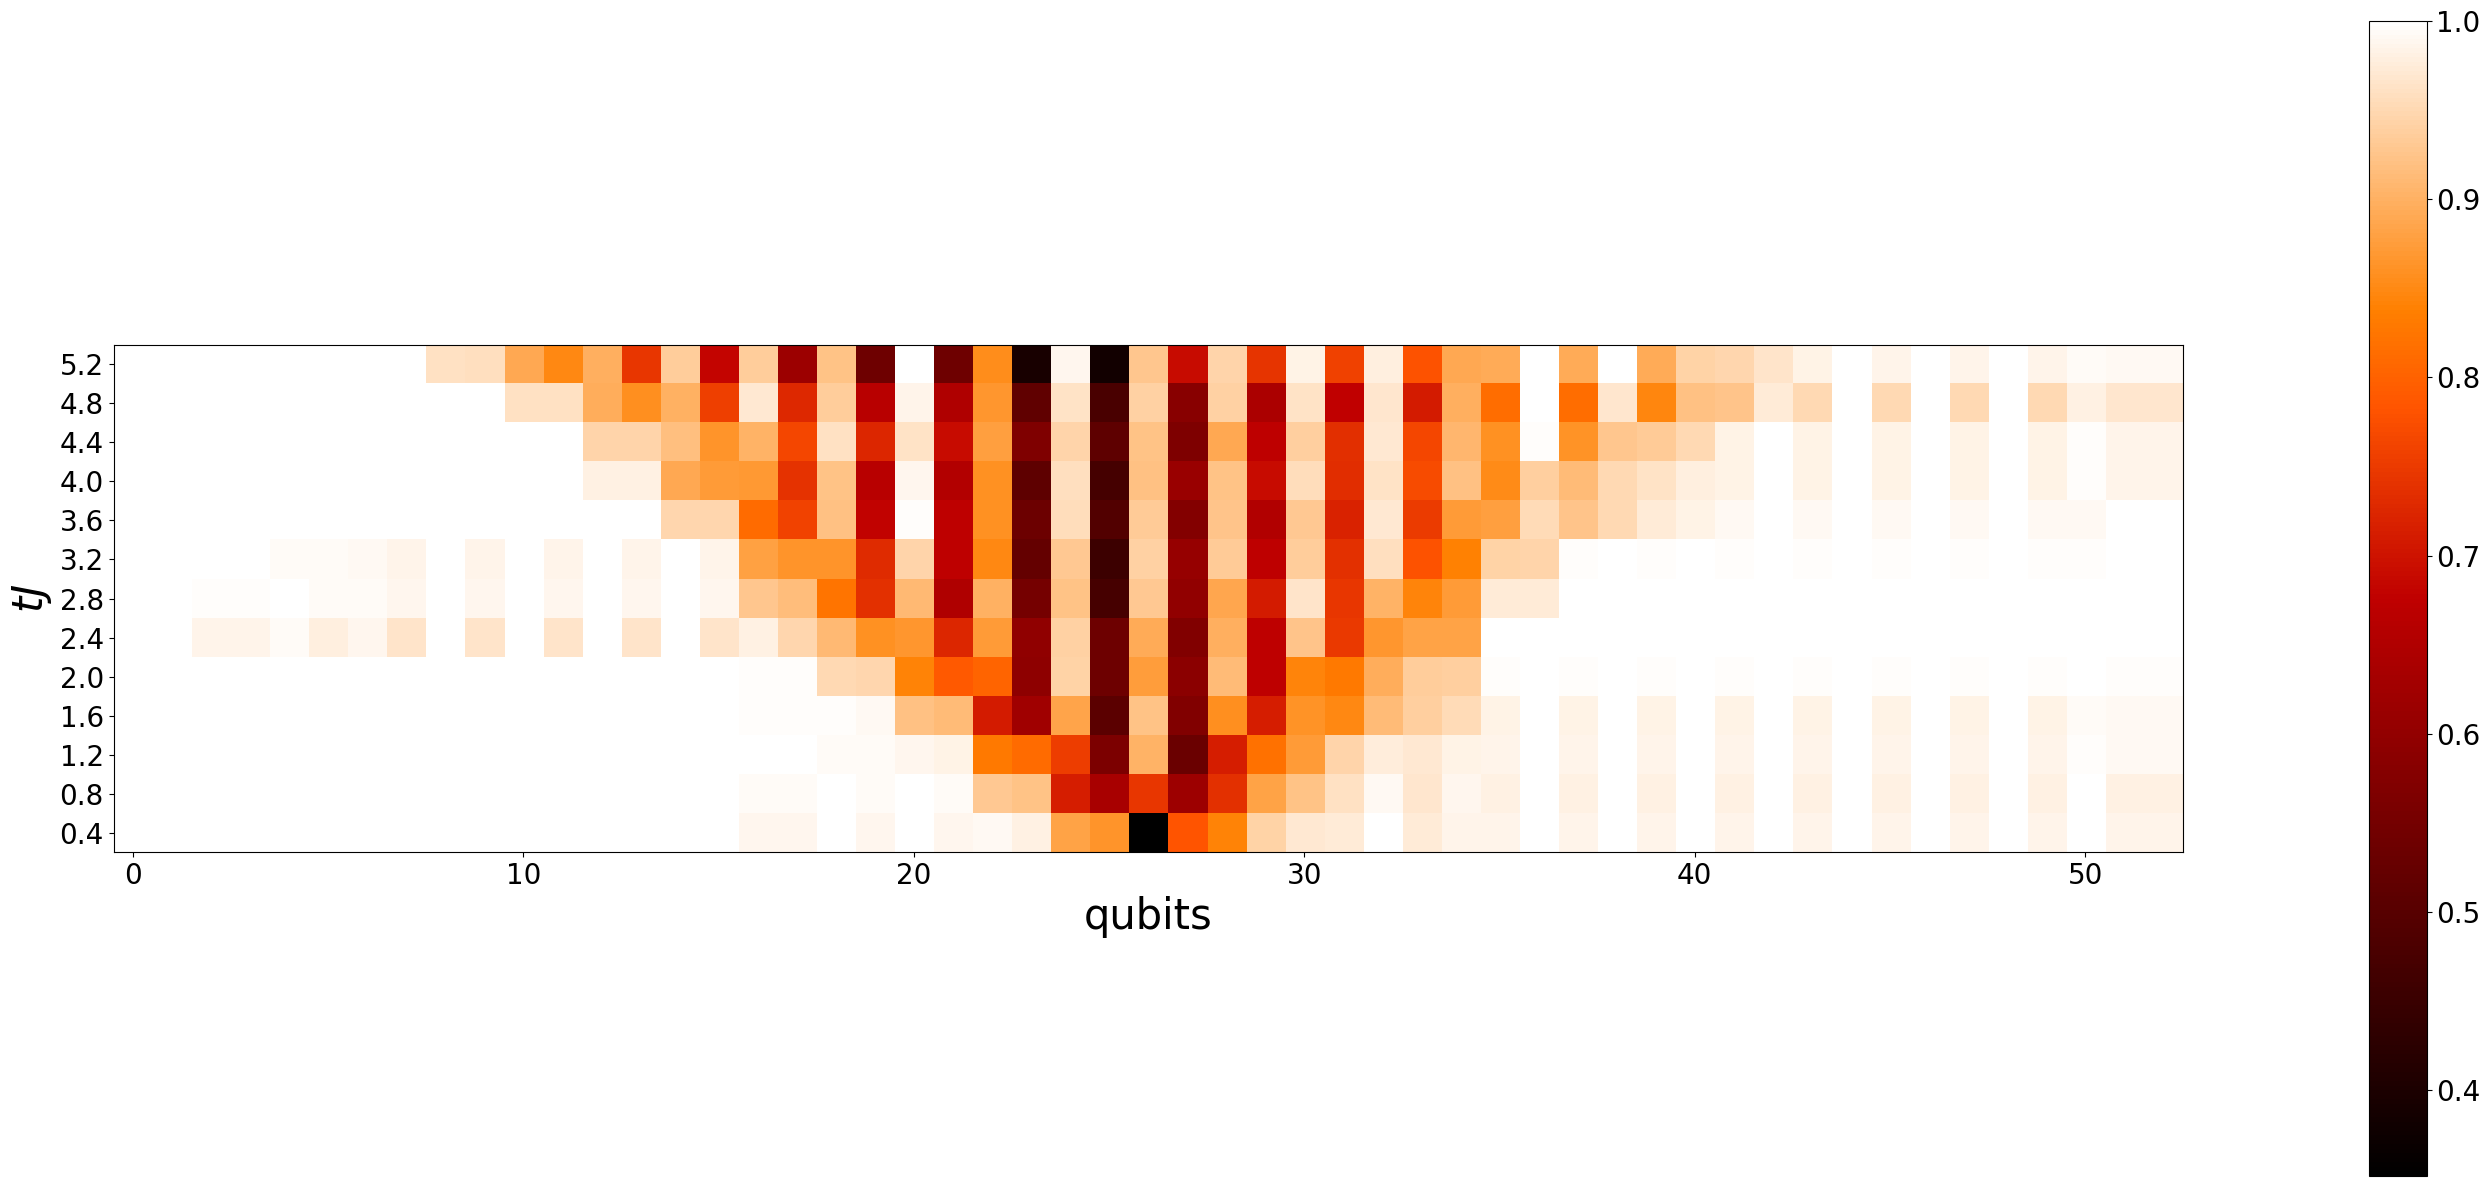

In [10]:

LabelSize = 20
plt.figure(1)
plt.figure(figsize=(30,15))
plt.imshow(evs_list_nopSym, interpolation='none',origin='lower',cmap = cmap)

y= np.arange(1, len(evs_list)+1, 1) * 0.4
plt.yticks(range(len(y)), np.round(y,2))
plt.xlabel('qubits',fontsize=1.5*LabelSize)
plt.ylabel(r'$tJ$',fontsize=1.5*LabelSize)
plt.tick_params(axis='both', which='major', labelsize=LabelSize)
cbar = plt.colorbar(fraction=0.03, pad=0.08)
cbar.ax.tick_params(labelsize=20)
plt.savefig(f"evs_all_noSym.png", dpi=100,bbox_inches='tight')


<Figure size 640x480 with 0 Axes>

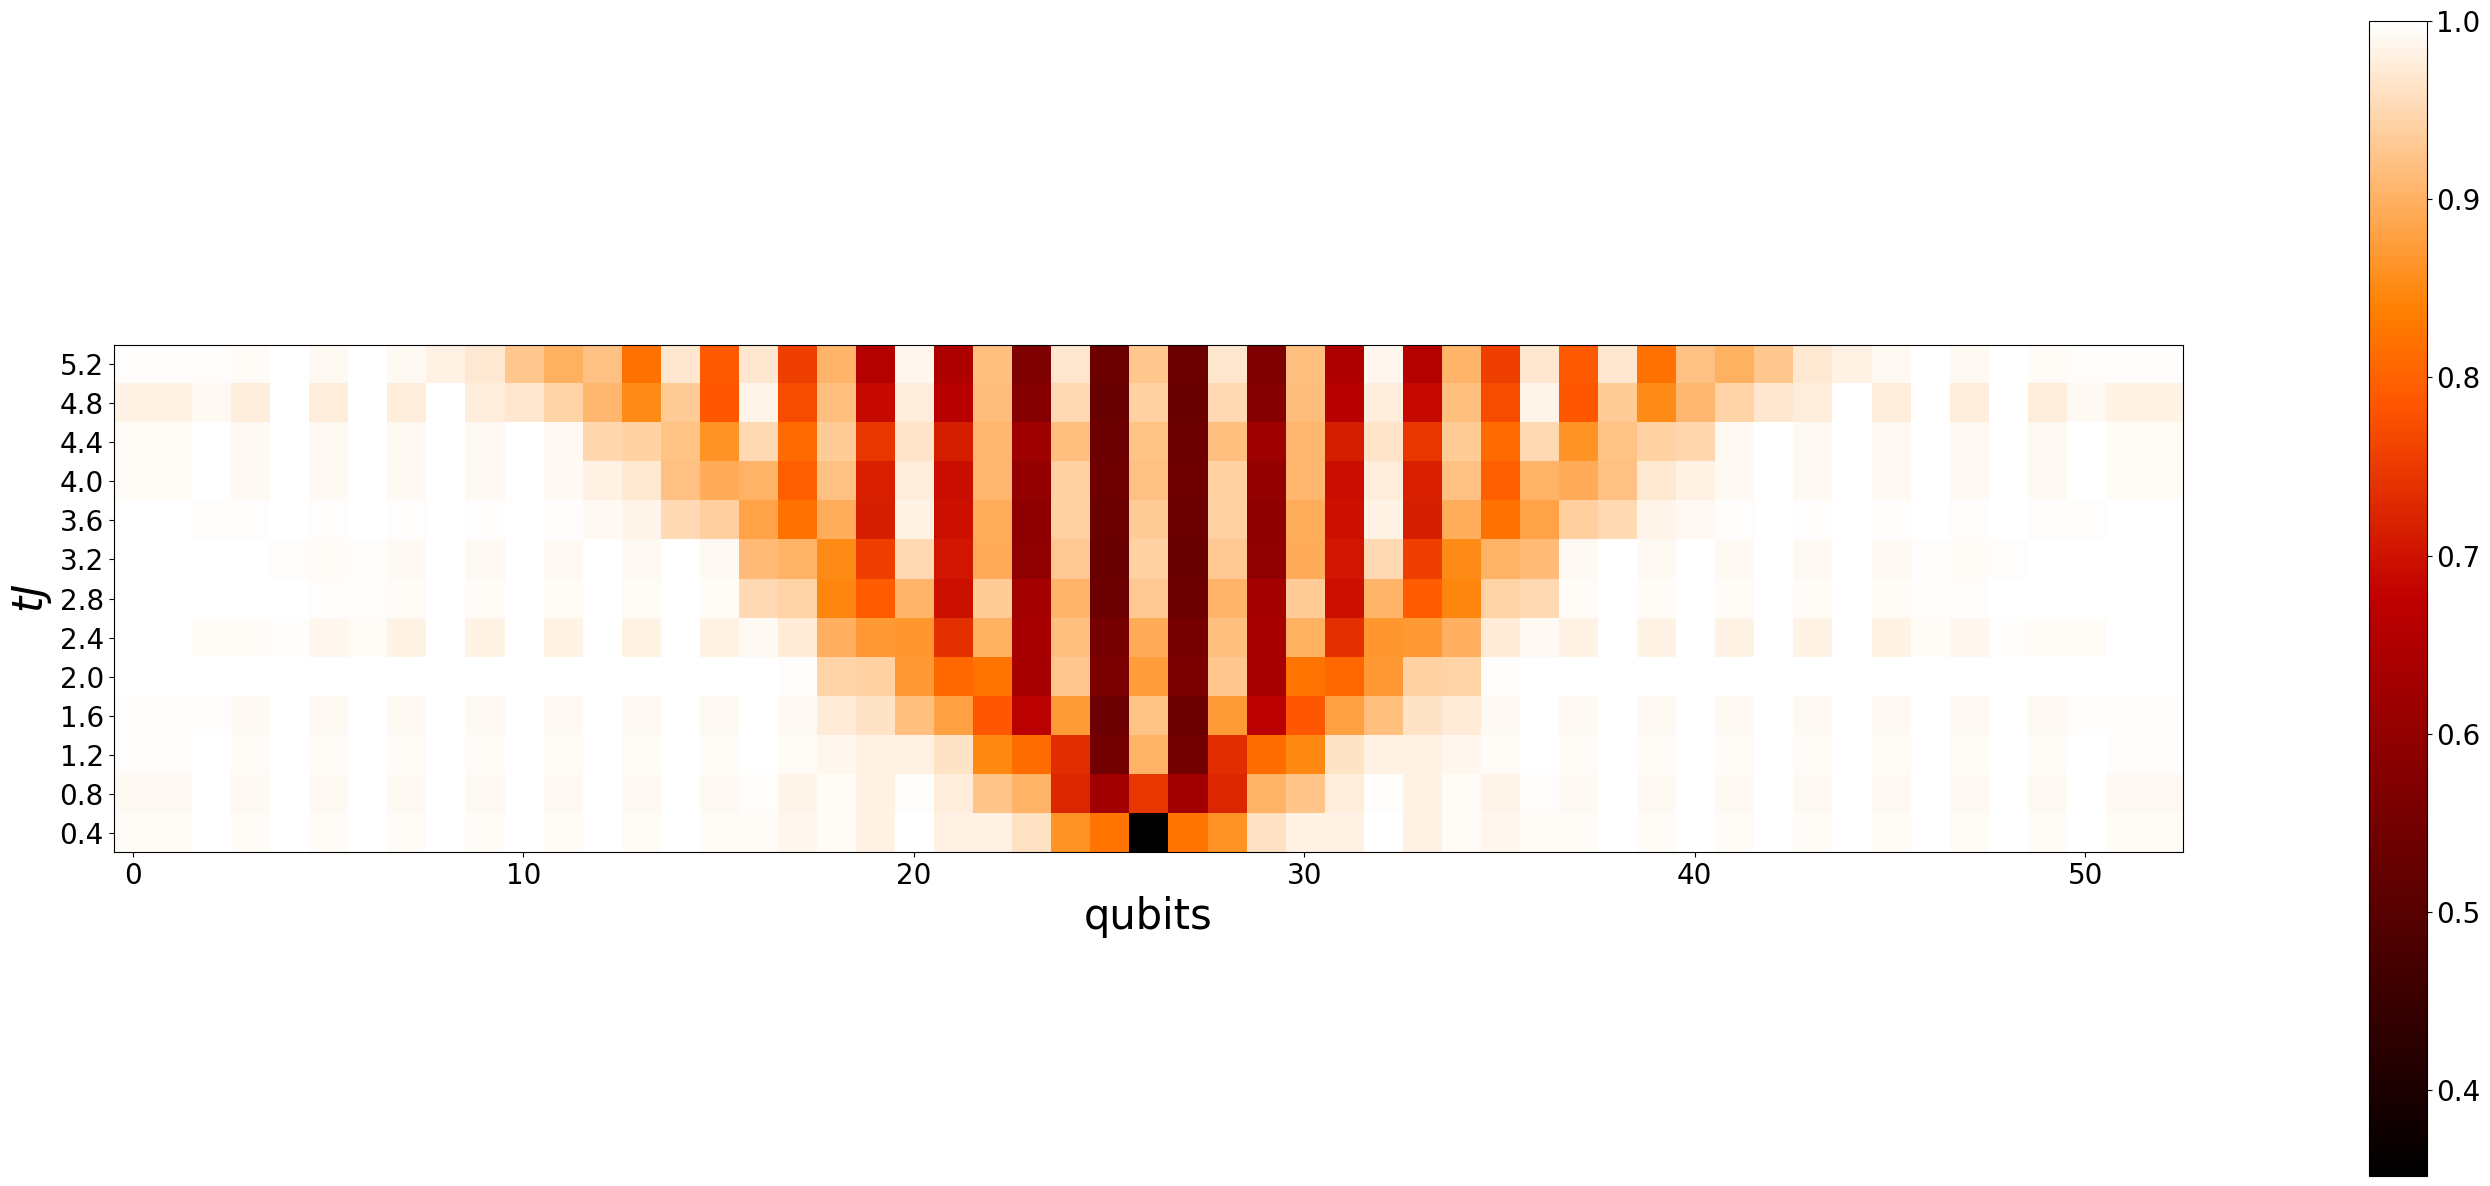

In [11]:

LabelSize = 20
plt.figure(1)
plt.figure(figsize=(30,15))
plt.imshow(evs_list, interpolation='none',origin='lower',cmap = cmap)

y= np.arange(1, len(evs_list)+1, 1) * 0.4
plt.yticks(range(len(y)), np.round(y,2))
plt.xlabel('qubits',fontsize=1.5*LabelSize)
plt.ylabel(r'$tJ$',fontsize=1.5*LabelSize)
plt.tick_params(axis='both', which='major', labelsize=LabelSize)
cbar = plt.colorbar(fraction=0.03, pad=0.08)
cbar.ax.tick_params(labelsize=20)
plt.savefig(f"evs_all.png", dpi=100,bbox_inches='tight')
